In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import scipy.signal as sig
import sys
import seaborn as sns
import gsw as gsw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
# import seawater as sw

from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")

In [2]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder



In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [4]:
dxx=0.5

In [5]:

chunks_new={'time_counter':10}

# M='01';mon_x=0

# path='/data/pacific/lrenault/SASI/CROCO/FULL/'
# listm=glob(path+'surf*.nc');listm.sort()
# # varf=xr.open_dataset(listm[-9:][xmon])
# varf=xr.open_dataset(listm[1:][mon_x],chunks=chunks_new)

# path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
# listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
# listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
# #vart=xr.open_dataset(listt[xmon])
# vart=xr.open_dataset(listt[1:][mon_x],chunks=chunks_new)



path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal',chunks=chunks_new)

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal',chunks=chunks_new)

In [6]:
# path='/data/pacific/lrenault/SASI/FULL/WRF/'
# listmw=glob(path+'wrf_*.nc');listmw.sort()
# # varf=xr.open_dataset(listm[-9:][xmon])
# varfw=xr.open_mfdataset(listmw[::2][-7:][mon_x],chunks=chunks_new)

# path='/data/pacific/lrenault/SASI/SMTH/WRF/'
# listtw=glob(path+'wrf_*.nc');listtw.sort()
# #vart=xr.open_dataset(listt[xmon])
# vartw=xr.open_mfdataset(listtw[::2][-7:][mon_x],chunks=chunks_new)


path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'wrf_*.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[::2][-7:],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'wrf_*.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[::2][-7:],chunks=chunks_new)

# Loading data

In [7]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())[:-1]

In [8]:
%%time

xend=800

tf=varf.temp#.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,120:-120,120:xend].compute();
tf=tf[:-1,1:-1,1:-1]

tt=vart.temp#.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,120:-120,120:xend].compute();
tt=tt[:-1,1:-1,1:-1]

shf=varf.shflx#.groupby("time_counter.dayofyear").mean() #positive values of heat flux mean transfer to the atmosphere.
shf=shf.chunk(chunks=chunks_new);
shf=shf[:,120:-120,120:xend].compute();
shf=shf[:-1,1:-1,1:-1]

sht=vart.shflx#.groupby("time_counter.dayofyear").mean()
sht=sht.chunk(chunks=chunks_new);
sht=sht[:,120:-120,120:xend].compute();
sht=sht[:-1,1:-1,1:-1]

sf=varf.salt#.groupby("time_counter.dayofyear").mean()
sf=sf.chunk(chunks=chunks_new);
sf=sf[:,120:-120,120:xend].compute();
sf=sf[:-1,1:-1,1:-1]

st=vart.salt#.groupby("time_counter.dayofyear").mean()
st=st.chunk(chunks=chunks_new);
st=st[:,120:-120,120:xend].compute();
st=st[:-1,1:-1,1:-1]

# rhof=varf.rho#.groupby("time_counter.dayofyear").mean()
# rhof=rhof.chunk(chunks=chunks_new);
# rhof=rhof[:,120:-120,120:xend].compute();
# rhof=rhof[:-1,1:-1,1:-1] +varf.rho0

# rhot=vart.rho#.groupby("time_counter.dayofyear").mean()
# rhot=rhot.chunk(chunks=chunks_new);
# rhot=rhot[:,120:-120,120:xend].compute();
# rhot=rhot[:-1,1:-1,1:-1] +vart.rho0


CPU times: user 17.4 s, sys: 43.5 s, total: 1min
Wall time: 5min 28s


# Computing $J_{\theta}^S$

In [9]:
cp=gsw.cp_t_exact(sf,tf,p=0).mean()
rho=1024
g=9.8

In [10]:
ct_f=gsw.CT_from_t(sf,tf,p=0)
alpha_f=gsw.alpha(sf,ct_f,p=0)
# lv_f=gsw.latentheat_evap_CT(sf,ct_f)


ct_t=gsw.CT_from_t(st,tt,p=0)
alpha_t=gsw.alpha(st,ct_t,p=0)
# lv_t=gsw.latentheat_evap_CT(st,ct_t)

In [11]:
J_theta_full=(shf)/(rho*cp) 
J_theta_smth=(sht)/(rho*cp)

# Computing $J_{s}^S$

##### Loading data from WRF

In [12]:
varfw.coords['2htime']=varfw.time_counter.dt.floor('2H')
vartw.coords['2htime']=vartw.time_counter.dt.floor('2H')

In [13]:
%%time
# chunks_new={'time_counter':40}
lhtf=regrid(varfw.LH.groupby('2htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,120:-120,120:xend][:,1:-1,1:-1]
lhtt=regrid(vartw.LH.groupby('2htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,120:-120,120:xend][:,1:-1,1:-1]
Pf=regrid(varfw.RAIN.groupby('2htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,120:-120,120:xend][:,1:-1,1:-1]
Pt=regrid(vartw.RAIN.groupby('2htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,120:-120,120:xend][:,1:-1,1:-1]

lhtf=lhtf[3:][::3]
lhtt=lhtt[3:][::3]

Pf=Pf[3:][::3]
Pt=Pt[3:][::3]

Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 1min 49s, sys: 5.33 s, total: 1min 54s
Wall time: 2min 21s


Frequency to 6h

In [14]:
L=2257*1000 # J/Kg

In [15]:
Evap_f=lhtf.compute()/(L*rho)# m/s   #*86400
Evap_t=lhtt.compute()/(L*rho)# m/s   #*86400 #mm/day

beta_f=gsw.beta(sf,ct_f,p=0)
beta_t=gsw.beta(st,ct_t,p=0)

In [16]:
EP_f=Evap_f-(Pf.compute()/(12*1000));

EP_t=Evap_t-(Pt.compute()/(12*1000));

In [17]:
J_s_full=(EP_f.data)*sf
J_s_smth=(EP_t.data)*st

In [18]:
Q_full=alpha_f.mean()*J_theta_full
Q_smth=alpha_t.mean()*J_theta_smth
EP_full=beta_f.mean()*J_s_full
EP_smth=beta_t.mean()*J_s_smth

# Loading z*

Find out the right signs

In [19]:
%%time
# z_star_full=xr.open_mfdataset('/data/pacific/iufarias/tseng_z_star/z_star_full*')['__xarray_dataarray_variable__'][:,0,1:-1,1:-1]
# z_star_smth=xr.open_mfdataset('/data/pacific/iufarias/tseng_z_star/z_star_smth*')['__xarray_dataarray_variable__'][:,0,1:-1,1:-1]


CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 15.7 µs


In [20]:
path='/data/pacific/iufarias/tseng_z_star/'
files_full=glob(path+'z_star_full*.nc');files_full.sort()
files_smth=glob(path+'z_star_smth*.nc');files_smth.sort()


In [21]:
%%time
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'


APE_flux_full=[]
APE_flux_smth=[]


# i_x=0
for i_x in range(len(files_full)):
# for i_x in range(124):

    z_star_full=xr.open_dataarray(files_full[i_x])[0,0,1:-1,1:-1]
    z_star_smth=xr.open_dataarray(files_smth[i_x])[0,0,1:-1,1:-1]




    Q_full_month=Q_full.sel(time_counter=z_star_full.ocean_time.data)
    Q_smth_month=Q_smth.sel(time_counter=z_star_smth.ocean_time.data)
    EP_full_month=EP_full.sel(time_counter=z_star_full.ocean_time.data)
    EP_smth_month=EP_smth.sel(time_counter=z_star_smth.ocean_time.data)


    Z_star_full=Q_full_month.copy(data=z_star_full.data)
    Z_star_smth=Q_smth_month.copy(data=z_star_smth.data)


    z_star_J_theta_full=xrft.isotropic_cross_spectrum((Z_star_full).drop(['nav_lat_rho', 'nav_lon_rho']),
                        (Q_full_month).drop(['nav_lat_rho', 'nav_lon_rho']),
                        dim=['x_rho','y_rho'],
                        nfactor=nf,truncate='True',scaling=scl,detrend='linear',
                        window=wdws,window_correction=wdw_cor).real

    z_star_J_theta_smth=xrft.isotropic_cross_spectrum((Z_star_smth).drop(['nav_lat_rho', 'nav_lon_rho']),
                        (Q_smth_month).drop(['nav_lat_rho', 'nav_lon_rho']),dim=['x_rho','y_rho'],
                        nfactor=nf,truncate='True',scaling=scl,detrend='linear',
                        window=wdws,window_correction=wdw_cor).real

    z_star_J_s_full=xrft.isotropic_cross_spectrum((Z_star_full).drop(['nav_lat_rho', 'nav_lon_rho']),
                        (EP_full_month).drop(['nav_lat_rho', 'nav_lon_rho']),
                        dim=['x_rho','y_rho'],
                        nfactor=nf,truncate='True',scaling=scl,detrend='linear',
                        window=wdws,window_correction=wdw_cor).real

    z_star_J_s_smth=xrft.isotropic_cross_spectrum((Z_star_smth).drop(['nav_lat_rho', 'nav_lon_rho']),
                        (EP_smth_month).drop(['nav_lat_rho', 'nav_lon_rho']),dim=['x_rho','y_rho'],
                        nfactor=nf,truncate='True',scaling=scl,detrend='linear',
                        window=wdws,window_correction=wdw_cor).real

    G_Ea_full=(g)*(z_star_J_theta_full - z_star_J_s_full)
    G_Ea_smth=(g)*(z_star_J_theta_smth - z_star_J_s_smth)



    # APE_flux_full=G_Ea_full
    # APE_flux_smth=G_Ea_smth

    APE_flux_full.append(G_Ea_full)
    APE_flux_smth.append(G_Ea_smth)

APE_flux_full_xr=xr.concat(APE_flux_full,dim='time_counter')
APE_flux_smth_xr=xr.concat(APE_flux_smth,dim='time_counter')


CPU times: user 3h 29min 6s, sys: 19h 31min 45s, total: 23h 51s
Wall time: 21min 7s


In [22]:
from pyspec import spectrum
import seawater as sw

T_ind=np.int((2*np.pi/sw.f(lat=36.6))/(60*60*6))
dxx=0.5

def plot_chi_error(ki,spec,sn,color='red',label=None,ci=0.95,alpha=0.25):

    Eu,El=spectrum.spec_error(spec,sn=sn, ci=ci)
    return plt.fill_between(ki,El,Eu, color=color, label=None,alpha=alpha)


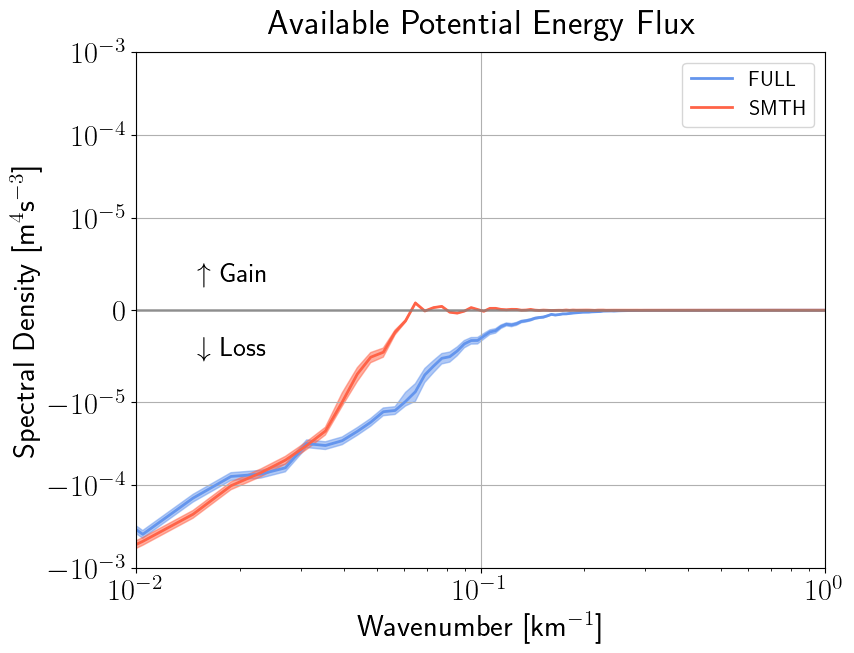

In [27]:
plt.figure(figsize=(9,7))

ci=0.95
T_ind=3
plt.plot(APE_flux_full_xr.freq_r/dxx,
         APE_flux_full_xr.mean(axis=0)/dxx*1e3,
         label='FULL',linewidth=2,color='cornflowerblue')


plot_chi_error(APE_flux_full_xr.freq_r/dxx,spec=APE_flux_full_xr.mean(axis=0)/dxx*1e3,ci=ci,alpha=0.5,sn=728/T_ind,color='cornflowerblue')


plt.plot(APE_flux_smth_xr.freq_r/dxx,
         APE_flux_smth_xr.mean(axis=0)/dxx*1e3,
         label='SMTH',linewidth=2,color='tomato')


plot_chi_error(APE_flux_smth_xr.freq_r/dxx,spec=APE_flux_smth_xr.mean(axis=0)/dxx*1e3,ci=ci,alpha=0.5,sn=728/T_ind,color='tomato')

plt.plot(APE_flux_smth_xr.freq_r/dxx,np.zeros(APE_flux_smth_xr[0].shape),linewidth=2,color='grey',alpha=0.7)


# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('symlog',linthresh=1e-5)
# plt.yscale('log')
plt.xscale('log')
# plt.title(r'$\frac{ \,b \,Bo}{N^2_r}$',fontsize=20)

# plt.title(r'$F_{PE}$',fontsize=25,y=1.05)
plt.title(r'Available Potential Energy Flux',fontsize=25,y=1.02)
# plt.title(r'APE Flux (T)',fontsize=25,y=1.02)


# plt.text(0.5,5e-3,r'F$_{PE}$',fontsize=25)
plt.text(1.5e-2,0.3e-5,r'$\uparrow$ Gain ',fontsize=20)
plt.text(1.5e-2,-0.5e-5,r'$\downarrow$ Loss ',fontsize=20)

# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
plt.ylim(-1e-3,1e-3)

plt.grid()

plt.tight_layout()



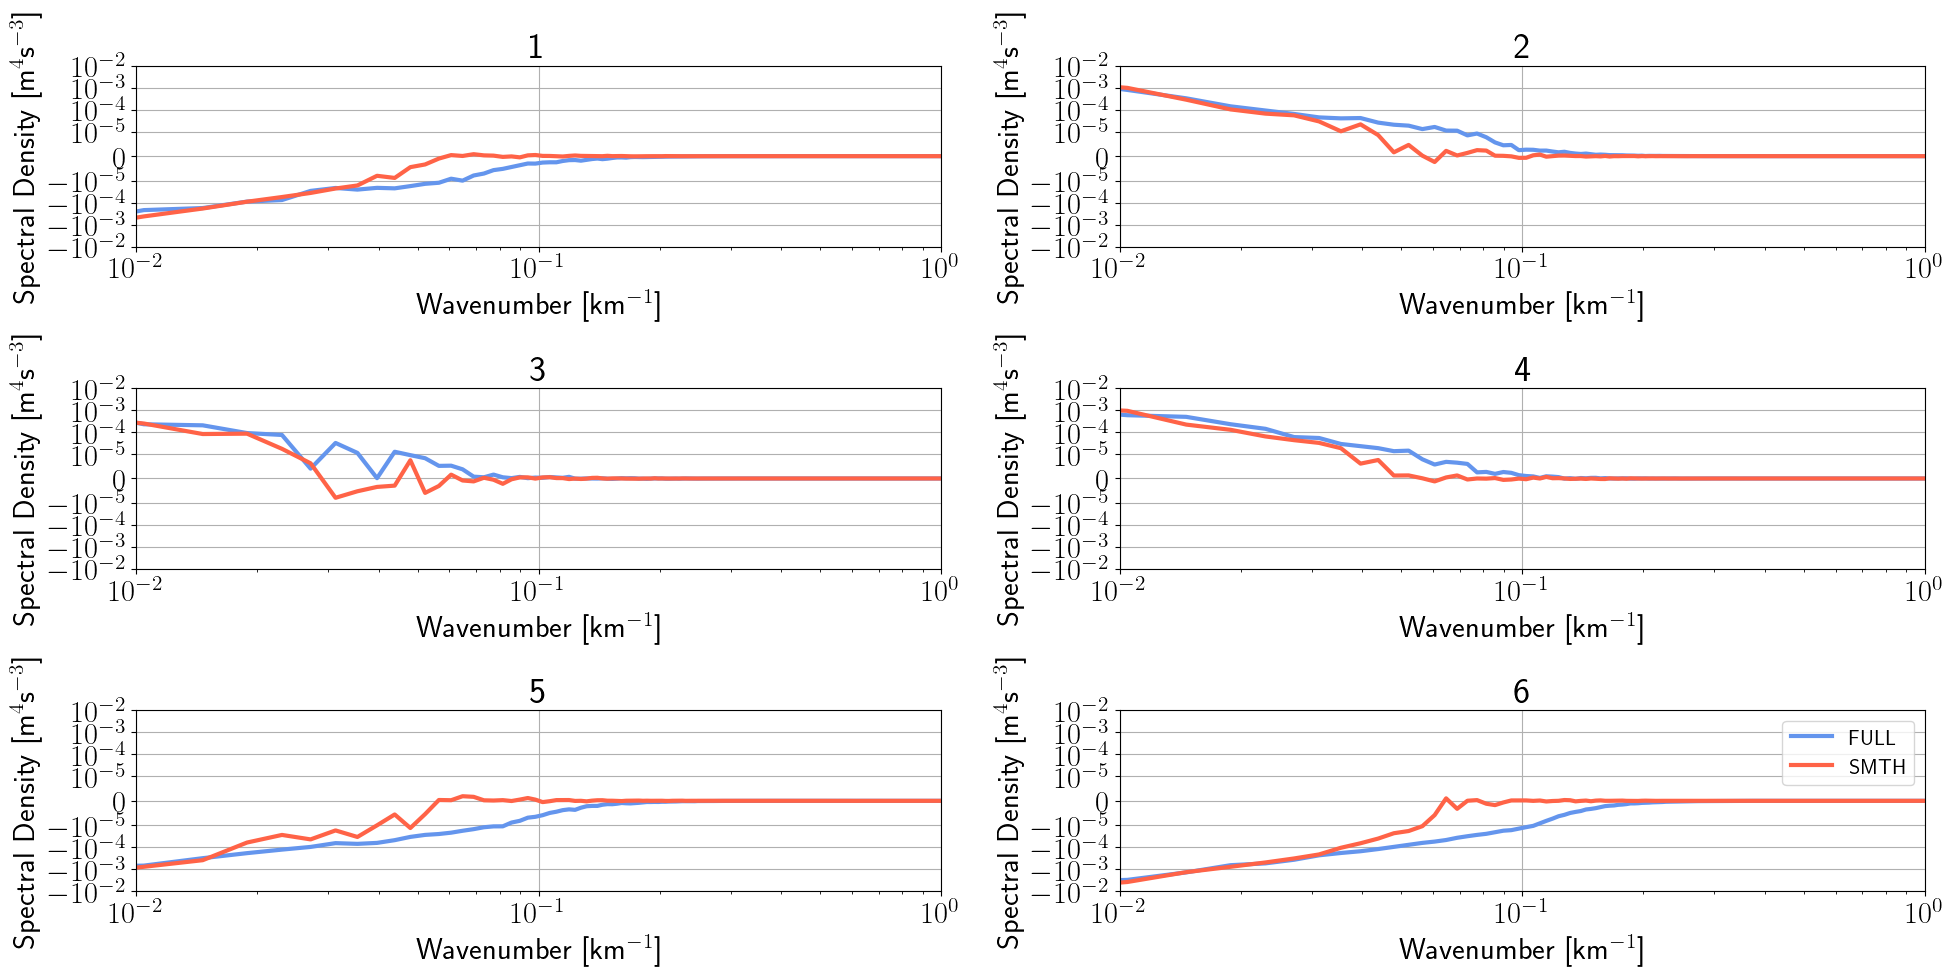

In [42]:
APE_flux_full_month=APE_flux_full_xr.groupby('time_counter.month').mean()
APE_flux_smth_month=APE_flux_smth_xr.groupby('time_counter.month').mean()


fig, axs = plt.subplots(figsize=(20,10),nrows=3, ncols=2)
axs=np.ravel(axs)
for ix in range(6):

    axs[ix].plot(APE_flux_full_month[ix].freq_r/dxx,
             APE_flux_full_month[ix]/dxx*1e3,
             label='FULL',linewidth=3,color='cornflowerblue')

    axs[ix].plot(APE_flux_smth_month[ix].freq_r/dxx,
             APE_flux_smth_month[ix]/dxx*1e3,
             label='SMTH',linewidth=3,color='tomato')
    axs[ix].set_title('{0}'.format(np.int_(APE_flux_full_month[ix].month.mean().data)))

    axs[ix].set_yscale('symlog',linthresh=1e-5)
    axs[ix].set_xscale('log')


    axs[ix].set_ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
    axs[ix].set_xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


    axs[ix].set_xlim(1/100,1)
    axs[ix].set_ylim(-1e-2,1e-2)

    axs[ix].grid()


plt.legend(prop={'size': 15})

# plt.title(r'APE Flux',fontsize=25,y=1.02)
plt.tight_layout()


## Older method

In [64]:
z_star_full=xr.open_dataarray('/data/pacific/iufarias/z_star/z_star_full_newmethod_M01.nc')[:-1,0,1:-1,1:-1]
z_star_smth=xr.open_dataarray('/data/pacific/iufarias/z_star/z_star_smth_newmethod_M01.nc')[:-1,0,1:-1,1:-1]

In [19]:
# %%time
# z_star_full=xr.open_mfdataset('/data/pacific/iufarias/z_star/z_star_full_newmethod_M*.nc')['__xarray_dataarray_variable__']
# z_star_smth=xr.open_mfdataset('/data/pacific/iufarias/z_star/z_star_smth_newmethod_M*.nc')['__xarray_dataarray_variable__']

In [23]:
# %%time

# nf=2
# wdws='hann' #'flattop','hann'
# wdw_cor=True
# scl='density'

# APE_flux_full=[]
# APE_flux_smth=[]


# # n_str=1
# for n_str in np.arange(1,2,1):
#     # z_star_full=xr.open_dataarray('/data/pacific/iufarias/z_star/z_star_full_newmethod_M0{0}'.format(n_str)+'.nc')[:-1,0,1:-1,1:-1]
#     # z_star_smth=xr.open_dataarray('/data/pacific/iufarias/z_star/z_star_smth_newmethod_M0{0}'.format(n_str)+'.nc')[:-1,0,1:-1,1:-1]


#     Q_full_month=Q_full.sel(time_counter=z_star_full.ocean_time.data)
#     Q_smth_month=Q_smth.sel(time_counter=z_star_smth.ocean_time.data)
#     EP_full_month=EP_full.sel(time_counter=z_star_full.ocean_time.data)
#     EP_smth_month=EP_smth.sel(time_counter=z_star_smth.ocean_time.data)


#     Z_star_full=Q_full_month.copy(data=z_star_full.data)
#     Z_star_smth=Q_smth_month.copy(data=z_star_smth.data)
    

#     z_star_J_theta_full=xrft.isotropic_cross_spectrum((Z_star_full).drop(['nav_lat_rho', 'nav_lon_rho']),
#                         (Q_full_month).drop(['nav_lat_rho', 'nav_lon_rho']),
#                         dim=['x_rho','y_rho'],
#                         nfactor=nf,truncate='True',scaling=scl,detrend='linear',
#                         window=wdws,window_correction=wdw_cor).real

#     z_star_J_theta_smth=xrft.isotropic_cross_spectrum((Z_star_smth).drop(['nav_lat_rho', 'nav_lon_rho']),
#                         (Q_smth_month).drop(['nav_lat_rho', 'nav_lon_rho']),dim=['x_rho','y_rho'],
#                         nfactor=nf,truncate='True',scaling=scl,detrend='linear',
#                         window=wdws,window_correction=wdw_cor).real

#     z_star_J_s_full=xrft.isotropic_cross_spectrum((Z_star_full).drop(['nav_lat_rho', 'nav_lon_rho']),
#                         (EP_full_month).drop(['nav_lat_rho', 'nav_lon_rho']),
#                         dim=['x_rho','y_rho'],
#                         nfactor=nf,truncate='True',scaling=scl,detrend='linear',
#                         window=wdws,window_correction=wdw_cor).real

#     z_star_J_s_smth=xrft.isotropic_cross_spectrum((Z_star_smth).drop(['nav_lat_rho', 'nav_lon_rho']),
#                         (EP_smth_month).drop(['nav_lat_rho', 'nav_lon_rho']),dim=['x_rho','y_rho'],
#                         nfactor=nf,truncate='True',scaling=scl,detrend='linear',
#                         window=wdws,window_correction=wdw_cor).real

#     G_Ea_full=(g*rho)*(z_star_J_theta_full - z_star_J_s_full)
#     G_Ea_smth=(g*rho)*(z_star_J_theta_smth - z_star_J_s_smth)
    
# #     G_Ea_full=(g*rho)*(z_star_J_theta_full)
# #     G_Ea_smth=(g*rho)*(z_star_J_theta_smth)

#     APE_flux_full.append(G_Ea_full)
#     APE_flux_smth.append(G_Ea_smth)

# APE_flux_full_xr=xr.concat(APE_flux_full,dim='time_counter')
# APE_flux_smth_xr=xr.concat(APE_flux_smth,dim='time_counter')

In [46]:
# nf=2
# wdws='hann' #'flattop','hann'
# wdw_cor=True
# scl='density'


# Q_full_month=Q_full.sel(time_counter=z_star_full.ocean_time.data)
# Q_smth_month=Q_smth.sel(time_counter=z_star_smth.ocean_time.data)
# EP_full_month=EP_full.sel(time_counter=z_star_full.ocean_time.data)
# EP_smth_month=EP_smth.sel(time_counter=z_star_smth.ocean_time.data)


# Z_star_full=Q_full_month.copy(data=z_star_full.data)
# Z_star_smth=Q_smth_month.copy(data=z_star_smth.data)


# z_star_J_theta_full=xrft.isotropic_cross_spectrum((Z_star_full).drop(['nav_lat_rho', 'nav_lon_rho']),
#                     (Q_full_month).drop(['nav_lat_rho', 'nav_lon_rho']),
#                     dim=['x_rho','y_rho'],
#                     nfactor=nf,truncate='True',scaling=scl,detrend='linear',
#                     window=wdws,window_correction=wdw_cor).real

# z_star_J_theta_smth=xrft.isotropic_cross_spectrum((Z_star_smth).drop(['nav_lat_rho', 'nav_lon_rho']),
#                     (Q_smth_month).drop(['nav_lat_rho', 'nav_lon_rho']),dim=['x_rho','y_rho'],
#                     nfactor=nf,truncate='True',scaling=scl,detrend='linear',
#                     window=wdws,window_correction=wdw_cor).real

# z_star_J_s_full=xrft.isotropic_cross_spectrum((Z_star_full).drop(['nav_lat_rho', 'nav_lon_rho']),
#                     (EP_full_month).drop(['nav_lat_rho', 'nav_lon_rho']),
#                     dim=['x_rho','y_rho'],
#                     nfactor=nf,truncate='True',scaling=scl,detrend='linear',
#                     window=wdws,window_correction=wdw_cor).real

# z_star_J_s_smth=xrft.isotropic_cross_spectrum((Z_star_smth).drop(['nav_lat_rho', 'nav_lon_rho']),
#                     (EP_smth_month).drop(['nav_lat_rho', 'nav_lon_rho']),dim=['x_rho','y_rho'],
#                     nfactor=nf,truncate='True',scaling=scl,detrend='linear',
#                     window=wdws,window_correction=wdw_cor).real

# G_Ea_full=(g*rho)*(z_star_J_theta_full - z_star_J_s_full)
# G_Ea_smth=(g*rho)*(z_star_J_theta_smth - z_star_J_s_smth)

# #     G_Ea_full=(g*rho)*(z_star_J_theta_full)
# #     G_Ea_smth=(g*rho)*(z_star_J_theta_smth)


In [28]:
Z_star_full=J_s_full.copy()
Z_star_full[:]=z_star_full.data

Z_star_smth=J_s_smth.copy()
Z_star_smth[:]=z_star_smth.data

## Spectral

In [67]:
%%time
# z_star_Bo_full=xrft.isotropic_cross_spectrum(xr.DataArray(-2 - z_star_full[:,0,:,:].data),
#                 xr.DataArray((-Bot_f+Bos_f).data),dim=['dim_1','dim_2'],
#                 nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
#                 window=wdws,window_correction=wdw_cor).real
# z_star_Bo_smth=xrft.isotropic_cross_spectrum(xr.DataArray(-2 - z_star_smth[:,0,:,:].data),
#                 xr.DataArray((-Bot_t+Bos_t).data),dim=['dim_1','dim_2'],
#                 nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
#                 window=wdws,window_correction=wdw_cor).real

CPU times: user 1e+03 ns, sys: 5 µs, total: 6 µs
Wall time: 13.6 µs


In [ ]:
%%time
z_star_full_spec=xrft.isotropic_power_spectrum(z_star_full[:,:11,:,:],
                dim=['eta_rho','xi_rho'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor)
            
            
z_star_smth_spec=xrft.isotropic_power_spectrum(z_star_smth[:,:11,:,:],
                dim=['eta_rho','xi_rho'],
                nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                window=wdws,window_correction=wdw_cor)

CPU times: user 28min 14s, sys: 1h 54min 23s, total: 2h 22min 37s
Wall time: 5min 50s


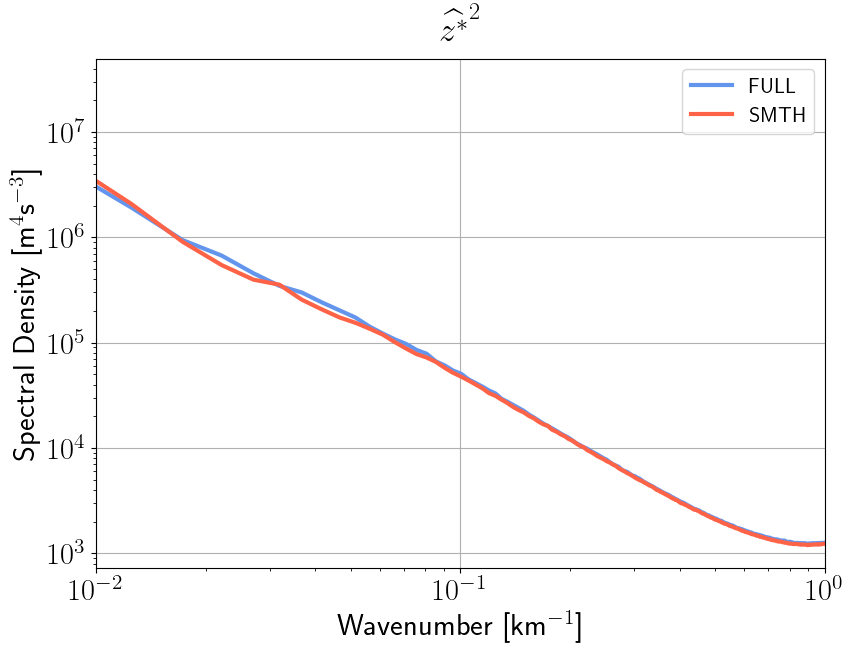

In [52]:
plt.figure(figsize=(9,7))


plt.plot(z_star_full_spec.freq_r/dxx,
         z_star_full_spec[:,0].mean(['ocean_time'])/dxx*1e3,
         label='FULL',linewidth=3,color='cornflowerblue')

plt.plot(z_star_smth_spec.freq_r/dxx,
         z_star_smth_spec[:,0].mean(['ocean_time'])/dxx*1e3,
         label='SMTH',linewidth=3,color='tomato')

# plt.plot(z_star_full_spec.freq_r/dxx,
#          z_star_full_spec.mean(['z_rho','ocean_time'])/dxx*1e3,
#          label='FULL',linewidth=3,color='cornflowerblue')

# plt.plot(z_star_smth_spec.freq_r/dxx,
#          z_star_smth_spec.mean(['z_rho','ocean_time'])/dxx*1e3,
#          label='SMTH',linewidth=3,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('log')
# plt.yscale('log')
plt.xscale('log')

plt.title(r'$\widehat{z^*}^2$',fontsize=25,y=1.02)


# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
# plt.ylim(-1e-5,1e-)5
plt.grid()

plt.tight_layout()